# Atividade Prática 4

## Classificação do Dataset Iris

In [1]:
# Inicialmente carrega-se as bibliotecas necessárias

from matplotlib import pyplot as plt
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.io import loadmat

import torch
from torch.utils.data import TensorDataset, DataLoader

import anfis
from membership import GaussMembFunc, make_gauss_mfs
from experimental import train_anfis, test_anfis

from cmenas import cmenas
from norm import normalize, denormalize

from sklearn.model_selection import KFold

In [2]:
# Define-se o tipo de dados dos tensores 
dtype = torch.float

In [3]:
# Define-se o método de carregamento dos dados

def data(partition=None, forced_idx=None):
    # loading data set
    data = pd.read_csv('data/iris.csv').dropna().drop(columns = ['Id'])

    data = data.to_numpy()
    length = len(data)

    # 70 / 30

    if partition is not None:
        idx = np.arange(length)
        np.random.shuffle(idx)

        eta = 0.7

        if partition == 'train':
            idx = idx[:int(eta * length)]
        if partition == 'test':
            idx = idx[int(eta * length):]

    if forced_idx is not None:
        idx = forced_idx

    data[data[:, data.shape[1] - 1] != 'Iris-setosa', data.shape[1]- 1] = 1
    data[data[:, data.shape[1] - 1] == 'Iris-setosa', data.shape[1]- 1] = -1

    x = torch.zeros((len(idx), data.shape[1] - 1))
    y = torch.zeros((len(idx), 1))
    for i, index in enumerate(idx):
        x[i, 0] = torch.tensor(data[index, 0])
        x[i, 1] = torch.tensor(data[index, 1])
        x[i, 2] = torch.tensor(data[index, 2])
        x[i, 3] = torch.tensor(data[index, 3])
        y[i, 0] = torch.tensor(data[index, 4])

    td = TensorDataset(x, y)
    return DataLoader(td, batch_size = 1024, shuffle = True), idx

In [4]:
# Define-se a criação do modelo

def model(data, n_rules):

    # numpy and norm
    x, y = data.dataset.tensors
    x = x.numpy()
    x, minimum, maximum = normalize(data = x)

    # cmeans
    # como o numero de entradas é constante n de regras = n de funcoes de
    # pertinencia = numero de centros

    modelo = cmenas(k = n_rules)
    modelo.train(data = x, MAX = 15, tol = 1e-2)
    centros = modelo.C

    # denorm
    centros = denormalize(data = centros, m = minimum, M = maximum)

    def mk_var(name, centros, i):
        return (name, make_gauss_mfs(1, [centros[n, i] for n in range(n_rules)]))

    invardefs = [mk_var(name, centros, i) for i, name in
                 enumerate(['SepalLengthCm', 'SepalWidthCm',
                  'PetalLengthCm', 'PetalWidthCm'])]

    outvars = ['Species']

    model = anfis.AnfisNet('iris', invardefs, outvars)
    return model

Note que pelo fato do número de entradas ser constante o número de regras está em função exclusivamente do número de fuções de pertinência associado a cada entrada. Ao usar o algoritmo cmeans para determinar o centro das funções gaussianas de pertinência o número de clusters corresponde diretamente ao número de funções de pertinência e portanto ao número de regras.

A variância das funções de pertinência é definida manualmente devido à sensibilidade do algoritmo de aprendizado híbrido a seu valor.

In [5]:
# Define-se procedimento de divisão dos dados de treinamento em kfolds

def kfold_data(idx, k=10): #assume indices preprocessados

    kfold = KFold(k)
    folds = []

    for i, (train, test) in enumerate(kfold.split(idx)):

        train_data, _ = data(forced_idx = train)
        test_data, _ = data(forced_idx = test)
        folds.append({'train':train_data, 'test':test_data})

    return folds

A busca em grade é feita para determinar o valor ótimo de regras para o sistema. Como o treinamento passa a ficar muito demorado com mais do que cinco regras o espaço da busca é limitado, para fins de demonstração, a esse valor. Os modelos são avaliados de acordo com o algoritmo de kfolds e a acurácia média de cada regra é registrada para que o número de regras que obteve a maior acurácia seja selecionado. Por mim o modelo vencedor é usado para classificar o conjunto de testes. Esse é o resultado visualizado.

1 loss: 32.78915429792414 duration: 0.00014781951904296875
2 loss: 23.563892337617656 duration: 0.00017881393432617188
3 loss: 23.563892337617656 duration: 0.00011801719665527344
1 loss: 50.65884270035713 duration: 0.0001277923583984375
2 loss: 24.293142416403274 duration: 0.0001227855682373047
3 loss: 24.293142416403274 duration: 0.00010442733764648438
1 loss: 51.494388271525395 duration: 0.00012636184692382812
2 loss: 24.281743805710907 duration: 0.00011539459228515625
3 loss: 24.281743805710907 duration: 9.989738464355469e-05
1 loss: 28.664054923702224 duration: 0.00017452239990234375
2 loss: 23.32766412972327 duration: 0.00021004676818847656
3 loss: 23.32766412972327 duration: 0.0001506805419921875
1 loss: 52.993703524118246 duration: 0.0002224445343017578
2 loss: 23.51414091527264 duration: 0.00019049644470214844
3 loss: 23.51414091527264 duration: 0.0002148151397705078
1 loss: 60.17329207685498 duration: 0.00022292137145996094
2 loss: 25.24614387523594 duration: 0.000673294067382

1 loss: 5.448916523642895 duration: 0.00033974647521972656
2 loss: 3.558136894640455 duration: 0.0003294944763183594
3 loss: 3.058436228402643 duration: 0.0004432201385498047
4 loss: 2.4071602962374072 duration: 0.0013604164123535156
5 loss: 2.2727673986510437 duration: 0.0004115104675292969
6 loss: 2.237029161797423 duration: 0.0005669593811035156
7 loss: 2.2251207752811895 duration: 0.00029969215393066406
8 loss: 2.2208907391055197 duration: 0.0008721351623535156
1 loss: 3.800416767520918 duration: 0.00026869773864746094
2 loss: 2.5819347959833663 duration: 0.000278472900390625
3 loss: 2.2751411643423025 duration: 0.0002899169921875
4 loss: 2.191140404749537 duration: 0.00023508071899414062
5 loss: 2.171287825221466 duration: 0.0016448497772216797
6 loss: 2.1666163970275933 duration: 0.0006337165832519531
1 loss: 8.48245329103977 duration: 0.00026535987854003906
2 loss: 4.271689840794458 duration: 0.0008375644683837891
3 loss: 2.7119493355274367 duration: 0.0002849102020263672
4 loss

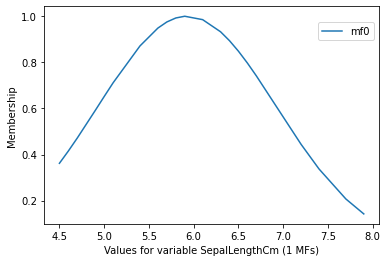

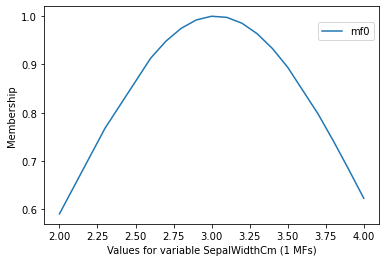

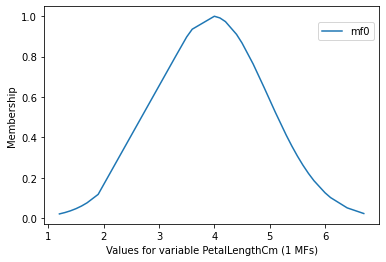

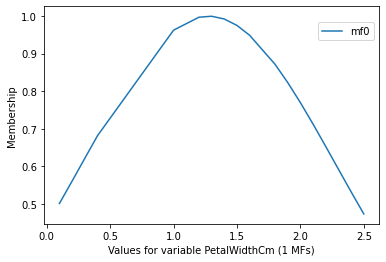

### Testing for 45 cases


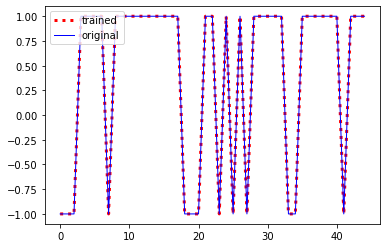

erro percentual =0.00%


In [6]:
# particao de train é usada para k folds

train_data, idx = data(partition = 'train')
folds = kfold_data(idx)

rule_range = range(5) # range de busca do grid search
fold_eval = np.zeros((len(rule_range), len(folds)))

for r, n_rules in enumerate(rule_range):
    for f, fold in enumerate(folds):
        fold_train_data = fold['train']
        fold_test_data = fold['test']
        anfis_model = model(fold_train_data, n_rules + 1)
        train_anfis(anfis_model, data = fold_train_data, epochs = 20, show_plots = False)
        _, _, perc_loss = test_anfis(anfis_model, data = fold_test_data, show_plots = False)
        fold_eval[r, f] = perc_loss

# particao de teste é avaliada com os parametros determinados

best_n_rule = np.argmin(np.mean(fold_eval, axis=1)) + 1

anfis_model = model(train_data, best_n_rule)
train_anfis(anfis_model, data = train_data, epochs = 20, show_plots = False)
test_data, _ = data(partition = 'test')
_, _, error = test_anfis(anfis_model, data = test_data, show_plots = True)
print('erro percentual ={:.2f}%'.format(error))

Também não foi possível mostrar uma curva de *underfitting* e *overfitting* já que o modelo não errou em nenhuma iteração no conjunto de teste, constante para o número de regras.

In [7]:
print(fold_eval)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Classificação da base Breast Cancer

A classificação da base Wisconsin Breast Cancer foi feita de maneira quase exatamente análoga. A primeira observação relevante é que os dados fornecidos para o trabalho geraram problemas de memória devido ao alto número de características. Usou-se portanto a versão reduzida em features da base disponível em https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

In [8]:
# Redefine-se uma rotina de carregamento dos dados

def data(partition=None, matlab=False, forced_idx=None):
    # loading data set
    data = pd.read_csv('data/wdbc.data')
    data = data.drop(columns = data.columns[0])
    # 70 / 30
    data = data.to_numpy()
    length = len(data)
    idx = np.arange(length)
    np.random.shuffle(idx)

    if partition is not None:
        idx = np.arange(length)
        np.random.shuffle(idx)

        eta = 0.7

        if partition == 'train':
            idx = idx[:int(eta * length)]
        if partition == 'test':
            idx = idx[int(eta * length):]

    if forced_idx is not None:
        idx = forced_idx

    # x, y
    if matlab:
        x = data[idx, 1:data.shape[1]]
        y = data[idx, 0]
        y[y == 'B'] = -1
        y[y == 'M'] = 1
        data[idx, 0] = y
    else:
        x = data[idx, :-1]
        y = data[idx, -1]
        y[y == 4] = -1
        y[y == 2] = 1
        data[idx, 0] = y

    # torch
    x = torch.tensor(np.array(x, dtype = np.float))
    y = torch.tensor(np.array(y, dtype = np.float))

    # copiei do anterior pq acima deu problema de float / double

    x = torch.zeros((len(idx), data.shape[1] - 1))
    y = torch.zeros((len(idx), 1))
    for i, index in enumerate(idx):
        for n_feature in range(data.shape[1] - 1):
            x[i, n_feature] = torch.tensor(data[index, n_feature + 1])

        y[i, 0] = torch.tensor(data[index, 0])

    td = TensorDataset(x, y)
    return DataLoader(td, batch_size = 1024, shuffle = True), idx


In [9]:
# Redefine-se uma rotina de criação do modelo

def model(data, n_rules):

    # numpy and norm
    x, y = data.dataset.tensors
    y = y.float()
    x = x.numpy()
    x, minimum, maximum = normalize(data = x)
    x = x.astype(float)

    # cmeans
    # como o numero de entradas é constante n de regras = n de funcoes de
    # pertinencia = numero de centros

    modelo = cmenas(k = n_rules)
    modelo.train(data = x, MAX = 15, tol = 1e-2)
    centros = modelo.C

    # denorm
    centros = denormalize(data = centros, m = minimum, M = maximum)

    names = [
            'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
            'smoothness_mean', 'compactness_mean', 'concavity_mean' 'conc_mean',
             'points_mean', 'symmetry_mean']

    def mk_var(name, centros, i):
        return (name, make_gauss_mfs(3, [centros[n, i] for n in range(n_rules)]))

    invardefs = [mk_var(name, centros, i) for i, name in enumerate(names)]

    outvars = ['diagnosis']

    model = anfis.AnfisNet('breast-cancer', invardefs, outvars)
    return model

1 loss: 720.2011970655213 duration: 0.00014472007751464844
2 loss: 460.0090999597968 duration: 0.0006957054138183594
3 loss: 460.0090999597968 duration: 0.0005803108215332031
1 loss: 635.7317762294226 duration: 0.00014853477478027344
2 loss: 456.1874648707226 duration: 0.0006797313690185547
3 loss: 456.1874648707226 duration: 0.0005691051483154297
1 loss: 709.7137293360345 duration: 0.0001742839813232422
2 loss: 455.3626355184325 duration: 0.0008311271667480469
3 loss: 455.3626355184325 duration: 0.000682830810546875
1 loss: 896.4594319094333 duration: 0.00024199485778808594
2 loss: 445.28579854019756 duration: 0.0008249282836914062
3 loss: 445.28579854019756 duration: 0.0004820823669433594
1 loss: 974.5223443057268 duration: 0.00025963783264160156
2 loss: 439.8553113795224 duration: 0.0011000633239746094
3 loss: 439.8553113795224 duration: 0.00023603439331054688
1 loss: 659.3582618027112 duration: 0.0001590251922607422
2 loss: 445.15428416235807 duration: 0.0005533695220947266
3 loss:

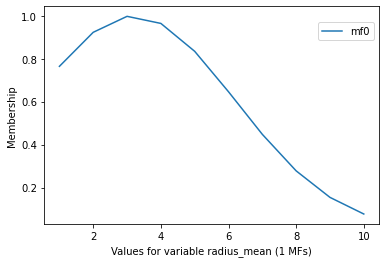

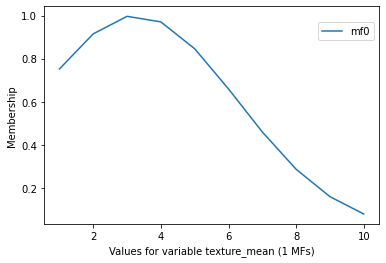

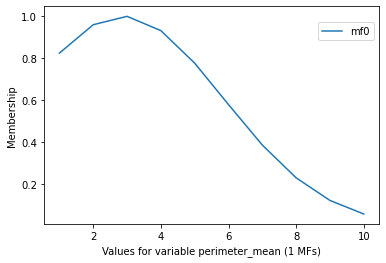

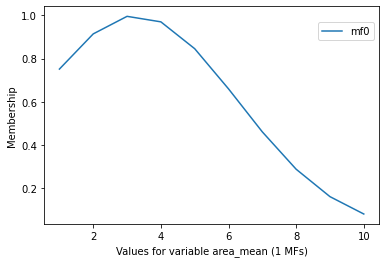

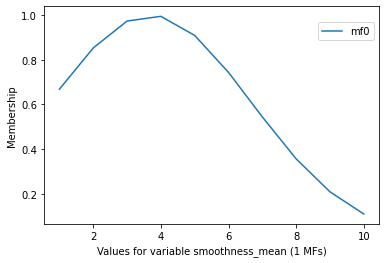

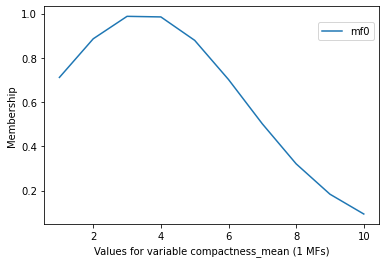

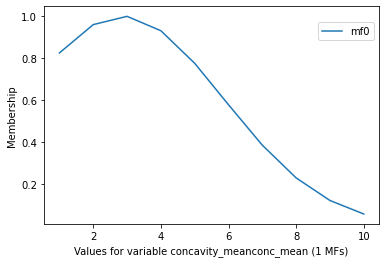

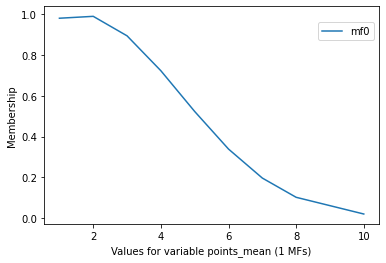

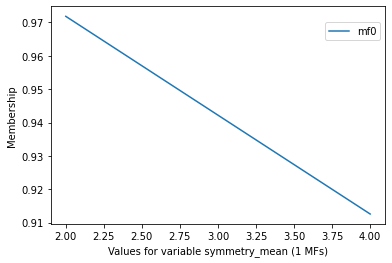

### Testing for 205 cases


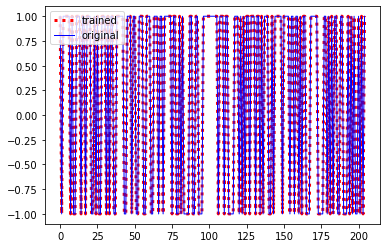

erro percentual =0.00%


In [10]:
train_data, idx = data(partition = 'train')
folds = kfold_data(idx)

rule_range = range(1)
fold_eval = np.zeros((len(rule_range), len(folds)))

for r, n_rules in enumerate(rule_range):
    for f, fold in enumerate(folds):
        fold_train_data = fold['train']
        fold_test_data = fold['test']
        anfis_model = model(fold_train_data, n_rules + 1)
        train_anfis(anfis_model, data = fold_train_data, epochs = 20, show_plots = False)
        _, _, perc_loss = test_anfis(anfis_model, data = fold_test_data, show_plots = False)
        fold_eval[r, f] = perc_loss

    # particao de teste é avaliada com os parametros determinados

best_n_rule = np.argmax(np.mean(fold_eval, axis=1)) + 1

anfis_model = model(train_data, best_n_rule)
train_anfis(anfis_model, data = train_data, epochs = 20, show_plots = False)
test_data, _ = data(partition = 'test')
_, _, error = test_anfis(anfis_model, data = test_data, show_plots = True)

print('erro percentual ={:.2f}%'.format(error))

Para essa base de dados, o espaço de busca de hiperparâmetros é ainda menor. Pelo tamanho, um aumento do número de regras $n\geq3$ já é suficiente para alocar mais memória que o disponível, impraticando a implementação. Da mesma forma, a solução se mostrou muito sensível a variância, mal condicionado, e, portanto, a escolha foi determinada por tentativa e erro das poucas escolhas com resposta.